Preprocessing and Cleaning


In [ ]:
import pandas as pd
import numpy as np

# Load the data

file_path = '/content/nba_stats_train.csv'
file_path2 = '/content/nba_stats_test.csv'
file_path3 = '/content/NBA_Player_Stats_2.csv'
df = pd.read_csv(file_path)
df2 = pd.read_csv(file_path2)
df3 = pd.read_csv(file_path3)

def clean_and_preprocess(df):
    # 1. Remove duplicate rows
    df = df.drop_duplicates()

    # 2. Create a 'Season_Start_Year' column
    if 'Season' in df.columns and df['Season'].dtype == 'object':
        df['Season_Start_Year'] = df['Season'].str[:4].astype(int)

    # if 'Player' in df.columns and 'Tm' in df.columns:
    #   # Merge on 'Player', 'Tm', and 'Season' to account for multiple seasons on the same team
    #   df = pd.merge(df, df3[['Player', 'Tm', 'Season']], on=['Player', 'Tm'], how='left')

    # 3. Convert 'MVP' to boolean (if it exists and is not already boolean)
    if 'MVP' in df.columns and df['MVP'].dtype != 'bool':
        # Assuming 'MVP' column contains values like 'Yes'/'No' or 1/0
        df['MVP'] = df['MVP'].astype(bool)

    # 4. Calculate 'Points_Per_Minute'
    if 'PTS' in df.columns and 'MP' in df.columns:
        # To avoid division by zero, replace zero minutes with NaN, then fill with 0
        df['Points_Per_Minute'] = df.apply(
            lambda row: row['PTS'] / row['MP'] if row['MP'] > 0 else 0, axis=1
        )

    # 5. Handle missing values for numeric columns by filling with 0
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].fillna(0)

    # Removing players with zero minutes played
    if 'MP' in df.columns:
        df = df[df['MP'] > 0]

    return df

# Apply the cleaning and preprocessing
cleaned_df = clean_and_preprocess(df)
cleaned_df2 = clean_and_preprocess(df2)
cleaned_df3 = clean_and_preprocess(df3)

# Save the cleaned dataset
cleaned_df.to_csv('cleaned_train_Stats.csv', index=False)
cleaned_df2.to_csv('cleaned_test_Stats.csv', index=False)
cleaned_df3.to_csv('cleaned_team_Stats.csv', index=False)


EDA

Feature Engineering (Selection and Scaling)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
def feature_selection_engineer(nba_data, file_name):
  # Step 1: Select the relevant features for clustering
  # 'Points_Per_Minute' already exists, so we'll directly select the necessary features
  features = ['PTS', 'AST', 'TRB', 'STL', 'BLK', 'Points_Per_Minute', 'FG%', 'eFG%', 'MP', 'TOV', 'FTA', 'Pos']

  # Step 2: Handle categorical variable 'Position' - Encoding it as numerical
  label_encoder = LabelEncoder()
  nba_data['Pos_encoded'] = label_encoder.fit_transform(nba_data['Pos'])
  features_encoded = features.copy()  # Copy to keep the original 'Pos' for plotting
  features_encoded.remove('Pos')
  features_encoded.append('Pos_encoded')  # Use the encoded position for clustering

  # Step 3: Create the final dataset for clustering
  nba_clustering_data = nba_data[features_encoded]

  # Step 4: Normalization - Normalize the selected features for fair clustering
  scaler = StandardScaler()
  nba_clustering_data_scaled = scaler.fit_transform(nba_clustering_data)

  # Convert the scaled data back into a DataFrame
  scaled_df = pd.DataFrame(nba_clustering_data_scaled, columns=features_encoded)

  # Add back the original 'Pos' column for later use in plotting
  scaled_df['Pos'] = nba_data['Pos']

  # Optional: If you want to check the shape and feature names of your final dataset
  print("Selected features for clustering:", features_encoded)
  print("Shape of the final data:", scaled_df.shape)

  # Save the final dataset for further use with the provided file name + "normalized"
  normalized_file_name = file_name + '_normalized.csv'
  scaled_df.to_csv(normalized_file_name, index=False)

  # Output the first few rows of the final dataset to inspect
  print(scaled_df.head())

file_path = '/content/cleaned_train_Stats.csv'
file_path2 = '/content/cleaned_test_Stats.csv'
df = pd.read_csv(file_path)
df2 = pd.read_csv(file_path2)

feature_selection_engineer(df,"train_data")
feature_selection_engineer(df2,"test_data")

Selected features for clustering: ['PTS', 'AST', 'TRB', 'STL', 'BLK', 'Points_Per_Minute', 'FG%', 'eFG%', 'MP', 'TOV', 'FTA', 'Pos_encoded']
Shape of the final data: (11653, 13)
        PTS       AST       TRB       STL       BLK  Points_Per_Minute  \
0 -1.003109 -1.000471 -0.832478 -1.192788 -0.194237          -0.582154   
1 -0.712295 -0.886541 -0.130205 -0.506650 -0.413647          -0.328377   
2 -0.609655 -0.772612 -0.088895 -0.735363  0.683406          -0.334320   
3  0.006186 -0.715648  0.695998 -0.277937  0.902817           0.496884   
4  0.125933 -0.259931 -0.460686  0.636914 -0.633058          -0.091451   

        FG%      eFG%        MP       TOV       FTA  Pos_encoded Pos  
0  0.648018  0.254893 -1.270933 -1.315942 -0.514047    -1.258584   C  
1  1.407845  0.978540 -0.817391 -0.933671 -0.750125    -0.796661  PF  
2  0.008651 -0.354030 -0.625896 -1.188518 -0.632086    -0.796661  PF  
3  0.638751  0.246068 -0.162276 -0.041705  0.253207    -0.796661  PF  
4  0.129111  0.484342 

Clustering (k-Mean)

    Rk           Player Pos  Age   Tm   G  GS    MP   FG  FGA  ...  TRB  AST  \
0   53     Calvin Booth   C   32  TOT   8   0   7.0  0.6  1.3  ...  1.4  0.0   
1  309  Arnett Moultrie  PF   22  PHI  47   0  11.5  1.7  2.9  ...  3.1  0.2   
2    5      Malik Allen  PF   23  MIA  12   2  13.4  1.8  4.3  ...  3.2  0.4   
3  212     Al Jefferson  PF   21  BOS  59   7  18.0  3.2  6.4  ...  5.1  0.5   
4   59    Avery Bradley  SG   29  LAL  49  44  24.2  3.5  7.8  ...  2.3  1.3   

   STL  BLK  TOV   PF  PTS    MVP  Points_Per_Minute   Season  
0  0.1  0.3  0.1  1.3  2.0  False           0.285714  2008-09  
1  0.4  0.2  0.4  0.9  3.7  False           0.321739  2012-13  
2  0.3  0.7  0.2  1.3  4.3  False           0.320896  2001-02  
3  0.5  0.8  1.1  2.8  7.9  False           0.438889  2005-06  
4  0.9  0.1  1.0  2.2  8.6  False           0.355372  2019-20  

[5 rows x 33 columns]
        PTS       AST       TRB       STL       BLK  Points_Per_Minute  \
0  0.735518 -0.206144  2.257995  0.172

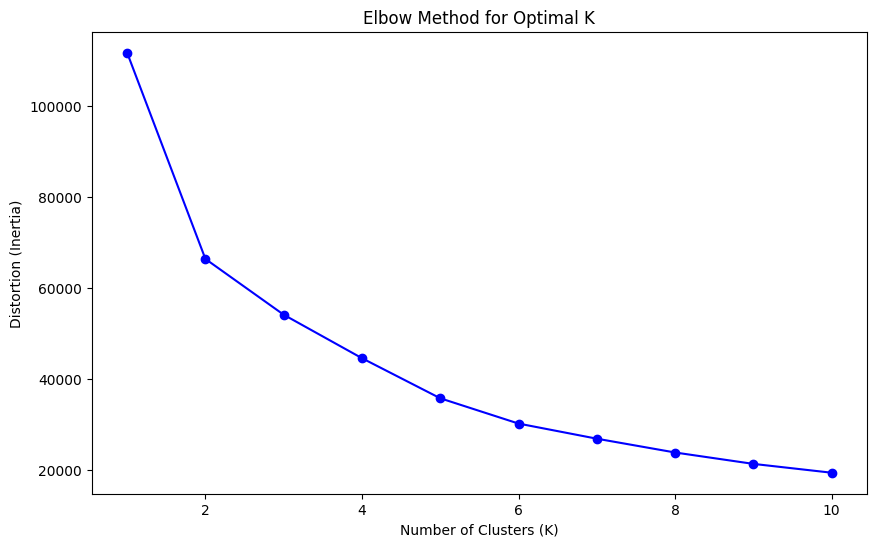

Training Inertia: 35687.67219092188
Training Silhouette Score: 0.3116
Testing Silhouette Score: 0.3133


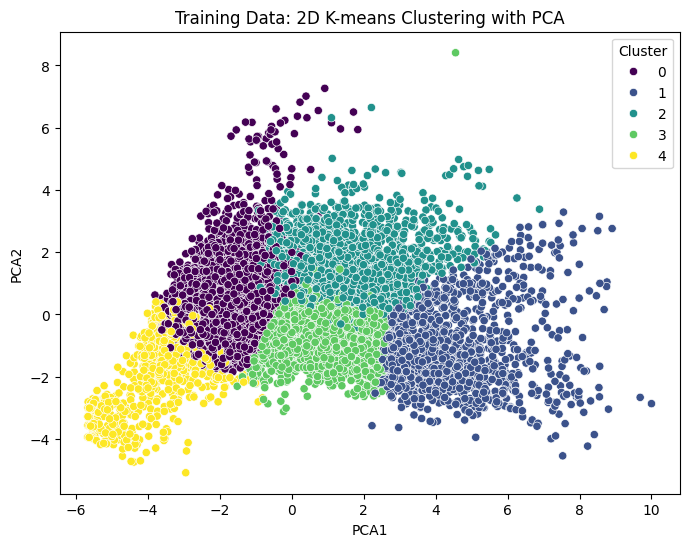

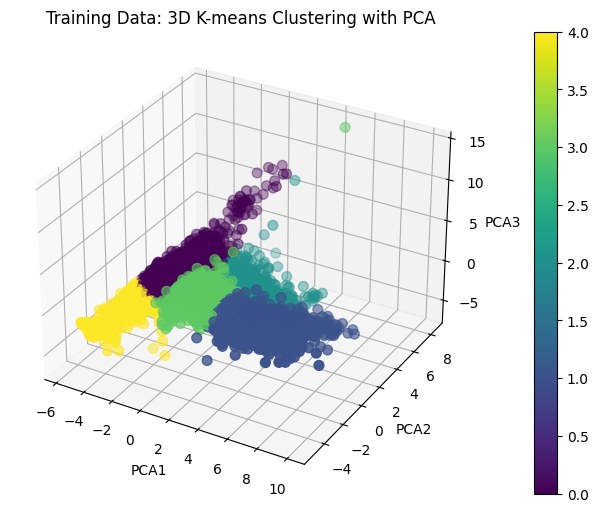

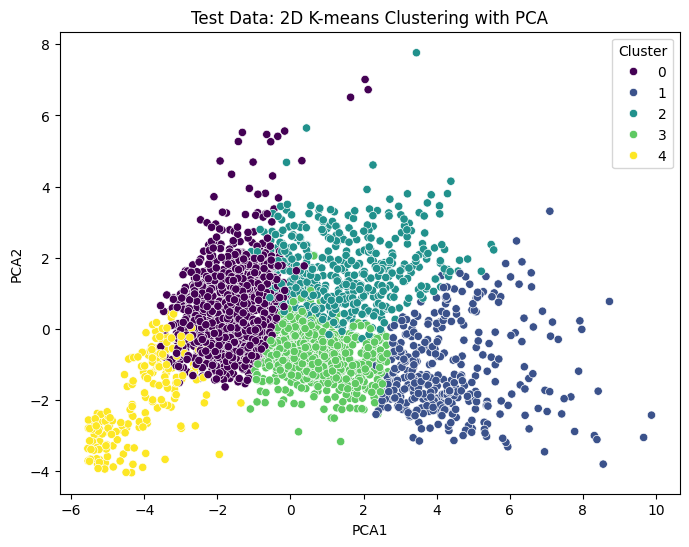

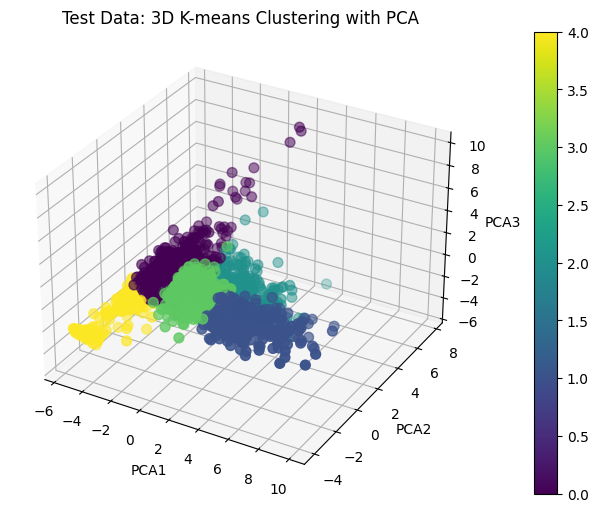


Top 10 Players by Rank within each Cluster (Train Data):

Cluster 0 (Train):
               Player Pos   PTS   Season   Tm  Cluster  Rank
9905   Doug McDermott  PF  11.3  2021-22  SAS        0   1.0
7167        Raja Bell  SG  11.0  2009-10  GSW        0   2.0
5336   Doug McDermott  PF  10.3  2019-20  IND        0   3.0
3166  Peja Stojaković  SF  10.0  2010-11  TOR        0   5.0
5012      Bryn Forbes  SG  10.0  2020-21  MIL        0   5.0
2748  James Ennis III  SF  10.0  2021-22  LAC        0   5.0
2532     Mike Muscala   C   9.7  2019-20  OKC        0   7.0
3485       Mike Scott  PF   9.6  2013-14  ATL        0   8.5
5788  Cameron Johnson  PF   9.6  2020-21  PHO        0   8.5
7571   Doug McDermott  SF   9.4  2015-16  CHI        0  10.0

Cluster 2 (Train):
                  Player Pos   PTS   Season   Tm  Cluster  Rank
4663        Al Jefferson   C  23.1  2008-09  MIN        2   1.0
6508  Kristaps Porziņģis  PF  22.7  2017-18  NYK        2   2.0
2246    Alonzo Mourning*   C  21.7  199

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Load the original and normalized datasets for training and testing
nba_train_original = pd.read_csv('cleaned_train_Stats.csv')
nba_test_original = pd.read_csv('cleaned_test_Stats.csv')

season_team_data = pd.read_csv('cleaned_team_Stats.csv')  # Load the dataset containing 'Season' and 'Tm'
nba_train_data = pd.read_csv('train_data_normalized.csv')
nba_test_data = pd.read_csv('test_data_normalized.csv')

season_team_data = season_team_data.drop_duplicates(subset=['Rk', 'Player', 'Tm'])

nba_test_original = nba_test_original.merge(
    season_team_data[['Rk', 'Player', 'Season', 'Tm']],
    on=['Rk', 'Player', 'Tm'],
    how='left'
)
nba_train_original = nba_train_original.merge(
    season_team_data[['Rk', 'Player', 'Season', 'Tm']],
    on=['Rk', 'Player', 'Tm'],
    how='left'
)
print(nba_train_original.head())
# Step 1: Merge the 'Pos' and 'Player' column back from the original dataset into the normalized data
nba_train_data['Pos'] = nba_train_original['Pos']
nba_train_data['Player'] = nba_train_original['Player']  # Include player names
nba_train_data['Season'] = nba_train_original['Season']
nba_train_data['Tm'] = nba_train_original['Tm']  # Include player names


# Perform left merge to preserve the order of nba_train_data




# Check the result to ensure 'Season' and 'Tm' have been added correctly

print(nba_test_data.head())







nba_test_data['Pos'] = nba_test_original['Pos']
nba_test_data['Player'] = nba_test_original['Player']  # Include player names
nba_test_data['Season'] = nba_test_original['Season']
nba_test_data['Tm'] = nba_test_original['Tm']  # Include player names











# Step 2: Drop 'Cluster', 'PCA1', 'PCA2', 'PCA3' columns if they exist to ensure original data is used for PCA
nba_train_data = nba_train_data.drop(columns=['Cluster', 'PCA1', 'PCA2', 'PCA3'], errors='ignore')
nba_test_data = nba_test_data.drop(columns=['Cluster', 'PCA1', 'PCA2', 'PCA3'], errors='ignore')

# Step 3: Ensure only numeric columns are selected for PCA and clustering
numeric_train_columns = nba_train_data.select_dtypes(include=['float64', 'int64']).columns
numeric_test_columns = nba_test_data.select_dtypes(include=['float64', 'int64']).columns

# Standardize the data for both training and testing sets
scaler = StandardScaler()
nba_train_numeric_data = scaler.fit_transform(nba_train_data[numeric_train_columns])
nba_test_numeric_data = scaler.transform(nba_test_data[numeric_test_columns])

# Define functions for KMeans and PCA
def find_optimal_k(data, max_k=10):
    distortions = []
    K = range(1, max_k + 1)
    for k in K:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    # Plot the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(K, distortions, 'bo-')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Distortion (Inertia)')
    plt.title('Elbow Method for Optimal K')
    plt.show()

# Perform PCA for dimensionality reduction
def run_pca(data, n_components=3):
    pca = PCA(n_components=n_components)
    pca_components = pca.fit_transform(data)
    return pca, pca_components, pca.explained_variance_ratio_

# Run K-means clustering on the PCA-reduced data
def run_kmeans(data, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(data)
    clustered_data = pd.DataFrame(data, columns=[f'PCA{i+1}' for i in range(data.shape[1])])
    clustered_data['Cluster'] = clusters
    return clustered_data, kmeans

# Step 6: Run the entire process
if __name__ == "__main__":
    # Debugging: Check the shape of the numeric data before running PCA
    print("Shape of numeric train data used for PCA:", nba_train_numeric_data.shape)
    print("Shape of numeric test data used for PCA:", nba_test_numeric_data.shape)

    # Step 1: Perform PCA for dimensionality reduction (use 3 components) for training data
    pca_train, pca_train_components, explained_variance_train = run_pca(nba_train_numeric_data, n_components=3)

    # Apply PCA to test data as well using the same PCA object
    pca_test_components = pca_train.transform(nba_test_numeric_data)

    # Step 2: Visualize the elbow method for optimal K
    find_optimal_k(pca_train_components, max_k=10)  # Call the elbow curve function

    # Step 3: Use the PCA components to run K-means clustering (use K=5 based on elbow plot)
    optimal_clusters = 5  # Based on previous elbow curve
    clustered_train_data, kmeans_model = run_kmeans(pca_train_components, optimal_clusters)
    clustered_test_data = pd.DataFrame(pca_test_components, columns=[f'PCA{i+1}' for i in range(pca_test_components.shape[1])])

    # Predict clusters for test data using the trained model
    test_clusters = kmeans_model.predict(pca_test_components)
    clustered_test_data['Cluster'] = test_clusters

    train_inertia = kmeans_model.inertia_
    print(f'Training Inertia: {train_inertia}')

    train_silhouette = silhouette_score(pca_train_components, clustered_train_data['Cluster'])
    test_silhouette = silhouette_score(pca_test_components, clustered_test_data['Cluster'])

    print(f'Training Silhouette Score: {train_silhouette:.4f}')
    print(f'Testing Silhouette Score: {test_silhouette:.4f}')

    # Add the original 'Pos', 'Player', and 'PTS' column to both datasets for visualization purposes
    clustered_train_data['Pos'] = nba_train_data['Pos']
    clustered_train_data['Player'] = nba_train_data['Player']  # Ensure player names are added
    clustered_train_data['PTS'] = nba_train_original['PTS'][:len(nba_train_data)]
    clustered_train_data['Season'] = nba_train_data['Season']
    clustered_train_data['Tm'] = nba_train_data['Tm']



    clustered_test_data['Pos'] = nba_test_data['Pos']
    clustered_test_data['Player'] = nba_test_data['Player']  # Ensure player names are added
    clustered_test_data['PTS'] = nba_test_original['PTS'][-len(nba_test_data):]
    clustered_test_data['Season'] = nba_test_data['Season']
    clustered_test_data['Tm'] = nba_test_data['Tm']



    ### RANK PLAYERS WITHIN EACH CLUSTER BASED ON PTS ###
    # Step 4: Rank players within each cluster by PTS for training data
    clustered_train_data['Rank'] = clustered_train_data.groupby('Cluster')['PTS'].rank(ascending=False)

    # Step 5: Rank players within each cluster by PTS for test data
    clustered_test_data['Rank'] = clustered_test_data.groupby('Cluster')['PTS'].rank(ascending=False)

    ### VISUALIZE THE RESULTS FOR BOTH TRAIN AND TEST DATA ###
    # Training Data Visualizations
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PCA1', y='PCA2', hue=clustered_train_data['Cluster'], palette='viridis', data=clustered_train_data)
    plt.title('Training Data: 2D K-means Clustering with PCA')
    plt.show()

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(clustered_train_data['PCA1'], clustered_train_data['PCA2'], clustered_train_data['PCA3'],
                         c=clustered_train_data['Cluster'], cmap='viridis', s=50)
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    plt.colorbar(scatter, ax=ax, pad=0.1)
    plt.title('Training Data: 3D K-means Clustering with PCA')
    plt.show()

    # Test Data Visualizations
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PCA1', y='PCA2', hue=clustered_test_data['Cluster'], palette='viridis', data=clustered_test_data)
    plt.title('Test Data: 2D K-means Clustering with PCA')
    plt.show()

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(clustered_test_data['PCA1'], clustered_test_data['PCA2'], clustered_test_data['PCA3'],
                         c=clustered_test_data['Cluster'], cmap='viridis', s=50)
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    plt.colorbar(scatter, ax=ax, pad=0.1)
    plt.title('Test Data: 3D K-means Clustering with PCA')
    plt.show()

    # Step 7: Compare and save the train and test clustered data
    clustered_train_data.to_csv('nba_train_clustered_ranked.csv', index=False)
    clustered_test_data.to_csv('nba_test_clustered_ranked.csv', index=False)

    # Merge on both 'Player' and 'Season' to ensure the correct season data is merged



    # Output the top 10 players by rank within each cluster for both train and test
    # Output the top 10 players by rank within each cluster for both train and test
    print("\nTop 10 Players by Rank within each Cluster (Train Data):")
    for cluster_num in clustered_train_data['Cluster'].unique():
        top_10_train = clustered_train_data[clustered_train_data['Cluster'] == cluster_num].sort_values(by='Rank').head(10)
        print(f"\nCluster {cluster_num} (Train):")
        print(top_10_train[['Player', 'Pos', 'PTS', 'Season', 'Tm', 'Cluster', 'Rank']])

    print("\nTop 10 Players by Rank within each Cluster (Test Data):")
    for cluster_num in clustered_test_data['Cluster'].unique():
        top_10_test = clustered_test_data[clustered_test_data['Cluster'] == cluster_num].sort_values(by='Rank').head(10)
        print(f"\nCluster {cluster_num} (Test):")
        print(top_10_test[['Player', 'Pos', 'PTS', 'Season', 'Tm' , 'Cluster', 'Rank']])


## DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Define a function to run DBSCAN and evaluate its performance
def run_dbscan(data, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(data)
    return clusters, dbscan

# Function to evaluate and rank players within each DBSCAN cluster
def evaluate_and_rank_dbscan(data, dbscan_labels, original_data):
    # Calculate DBSCAN silhouette score
    silhouette = silhouette_score(data, dbscan_labels)
    print(f'DBSCAN Silhouette Score: {silhouette:.4f}')

    # Add the DBSCAN cluster labels to the DataFrame
    dbscan_clustered_data = pd.DataFrame(data, columns=[f'PCA{i+1}' for i in range(data.shape[1])])
    dbscan_clustered_data['Cluster'] = dbscan_labels
    dbscan_clustered_data['Pos'] = original_data['Pos']
    dbscan_clustered_data['Player'] = original_data['Player']
    dbscan_clustered_data['PTS'] = original_data['PTS']
    dbscan_clustered_data['Season'] = original_data['Season']
    dbscan_clustered_data['Tm'] = original_data['Tm']

    # Rank players within each DBSCAN cluster by points (PTS)
    dbscan_clustered_data['Rank'] = dbscan_clustered_data.groupby('Cluster')['PTS'].rank(ascending=False)

    # Display top 10 players by rank within each DBSCAN cluster
    unique_clusters = dbscan_clustered_data['Cluster'].unique()
    for cluster_num in unique_clusters:
        if cluster_num != -1:  # Exclude noise points (-1)
            top_10 = dbscan_clustered_data[dbscan_clustered_data['Cluster'] == cluster_num].sort_values(by='Rank').head(10)
            print(f"\nCluster {cluster_num} (DBSCAN):")
            print(top_10[['Player', 'Pos', 'PTS', 'Season', 'Tm', 'Cluster', 'Rank']])

    return dbscan_clustered_data

# Set parameters for DBSCAN
eps = 0.5
min_samples = 5

# Apply DBSCAN to the PCA-reduced training data
dbscan_train_labels, dbscan_model = run_dbscan(pca_train_components, eps=eps, min_samples=min_samples)
dbscan_test_labels = dbscan_model.fit_predict(pca_test_components)

# Evaluate DBSCAN for training and testing sets
print("Training Data (DBSCAN) Evaluation:")
dbscan_clustered_train_data = evaluate_and_rank_dbscan(pca_train_components, dbscan_train_labels, nba_train_data)

print("\nTesting Data (DBSCAN) Evaluation:")
dbscan_clustered_test_data = evaluate_and_rank_dbscan(pca_test_components, dbscan_test_labels, nba_test_data)

# Save DBSCAN clustered data for further analysis or visualization
dbscan_clustered_train_data.to_csv('nba_train_dbscan_clustered.csv', index=False)
dbscan_clustered_test_data.to_csv('nba_test_dbscan_clustered.csv', index=False)

Training Data (DBSCAN) Evaluation:
DBSCAN Silhouette Score: -0.2774

Cluster 0 (DBSCAN):
                 Player Pos       PTS   Season   Tm  Cluster  Rank
2697       Kobe Bryant*  SG  4.060474  2001-02  LAL        0   1.0
8190       Kobe Bryant*  SG  3.786767  2002-03  LAL        0   2.0
1288   Jerry Stackhouse  SG  3.752553  2000-01  DET        0   3.0
8641     Gilbert Arenas  PG  3.667020  2005-06  WAS        0   4.0
11257   Carmelo Anthony  SF  3.598593  2005-06  DEN        0   5.5
10964     Isaiah Thomas  PG  3.598593  2016-17  BOS        0   5.5
7956     Damian Lillard  PG  3.581486  2019-20  POR        0   7.0
4519    Michael Jordan*  SG  3.564380  1997-98  CHI        0   8.0
7871         Trae Young  PG  3.513060  2021-22  ATL        0  10.0
9413       LeBron James  SF  3.513060  2008-09  CLE        0  10.0

Cluster 1 (DBSCAN):
                 Player Pos       PTS   Season   Tm  Cluster  Rank
7131       Marcus Banks  PG -1.003109  2010-11  TOR        1   1.5
3066          Gary 

## DBSCAN Fine-tuning

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Function to evaluate DBSCAN with a given set of parameters
def dbscan_experiment(data, original_data, eps_values, min_samples_values, test_data=None):
    best_score = -1  # To track the best silhouette score
    best_params = {'eps': None, 'min_samples': None}
    best_clustered_data = None

    # Grid search over eps and min_samples values
    for eps in eps_values:
        for min_samples in min_samples_values:
            # Apply DBSCAN with the current parameters
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)

            # Only calculate silhouette score if there are more than 1 clusters
            if len(set(labels)) > 1:
                score = silhouette_score(data, labels)
                print(f"DBSCAN with eps={eps}, min_samples={min_samples} -> Silhouette Score: {score:.4f}, Clusters: {len(set(labels)) - (1 if -1 in labels else 0)}")

                # Update the best score if the current one is better
                if score > best_score:
                    best_score = score
                    best_params = {'eps': eps, 'min_samples': min_samples}
                    best_clustered_data = labels

    print(f"\nBest DBSCAN params: eps={best_params['eps']}, min_samples={best_params['min_samples']} with Silhouette Score: {best_score:.4f}")

    # Evaluate silhouette score on testing data using the best parameters
    if test_data is not None and best_clustered_data is not None:
        best_dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
        test_labels = best_dbscan.fit_predict(test_data)

        # Calculate silhouette score for test data only if there are more than 1 clusters
        if len(set(test_labels)) > 1:
            test_score = silhouette_score(test_data, test_labels)
            print(f"Testing Data -> Silhouette Score: {test_score:.4f}, Clusters: {len(set(test_labels)) - (1 if -1 in test_labels else 0)}")
        else:
            print("Testing Data -> Silhouette Score cannot be calculated due to insufficient clusters.")

    return best_params, best_clustered_data

# Define parameter ranges for grid search
eps_values = np.arange(0.1, 1.1, 0.1)  # Try eps from 0.1 to 1.0
min_samples_values = range(3, 11)       # Try min_samples from 3 to 10

# Run the experiment on the PCA-reduced training data
best_params, best_labels = dbscan_experiment(pca_train_components, nba_train_data, eps_values, min_samples_values, test_data=pca_test_components)

# Evaluate and rank players within the best DBSCAN cluster configuration
print("\nBest DBSCAN Training Data Evaluation:")
dbscan_clustered_train_data = evaluate_and_rank_dbscan(pca_train_components, best_labels, nba_train_data)

DBSCAN with eps=0.1, min_samples=3 -> Silhouette Score: -0.5297, Clusters: 595
DBSCAN with eps=0.1, min_samples=4 -> Silhouette Score: -0.6172, Clusters: 242
DBSCAN with eps=0.1, min_samples=5 -> Silhouette Score: -0.6456, Clusters: 114
DBSCAN with eps=0.1, min_samples=6 -> Silhouette Score: -0.6337, Clusters: 57
DBSCAN with eps=0.1, min_samples=7 -> Silhouette Score: -0.5977, Clusters: 20
DBSCAN with eps=0.1, min_samples=8 -> Silhouette Score: -0.3645, Clusters: 7
DBSCAN with eps=0.1, min_samples=9 -> Silhouette Score: -0.3115, Clusters: 4
DBSCAN with eps=0.1, min_samples=10 -> Silhouette Score: 0.4712, Clusters: 3
DBSCAN with eps=0.2, min_samples=3 -> Silhouette Score: -0.6015, Clusters: 267
DBSCAN with eps=0.2, min_samples=4 -> Silhouette Score: -0.6102, Clusters: 175
DBSCAN with eps=0.2, min_samples=5 -> Silhouette Score: -0.6277, Clusters: 127
DBSCAN with eps=0.2, min_samples=6 -> Silhouette Score: -0.5802, Clusters: 93
DBSCAN with eps=0.2, min_samples=7 -> Silhouette Score: -0.57